<a href="https://colab.research.google.com/github/saltysallysmine/MIPT-CV-Homeworks/blob/main/CV_HW_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision. Homework 1. Тренировочный цикл и linear probe на ViT-Tiny

Датасет: CIFAR-100 (из torchvision)

## CNN

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import random

In [18]:
# SEEDS #
seed = 124
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [19]:
# CONSTANTS #

CIFAR_MEAN = (0.5071, 0.4867, 0.4408)
# CIFAR_STD = (0.2675, 0.2565, 0.2761)
CIFAR_STD = (0.2470, 0.2435, 0.2616)

CLASS_CNT = 5

LR = 1e-3 * 5
BATCH_SIZE = 64

In [20]:
# 5 классов выбора
selected_classes = list(range(CLASS_CNT))

# Трансформации с аугментациями
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
])

In [21]:
# DATASET #

full_train = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)

# Фильтрация по выбранным классам
indices = [i for i, label in enumerate(full_train.targets) if label in selected_classes]
subset = Subset(full_train, indices)

train_size = int(0.8 * len(subset))
val_size = len(subset) - train_size
train_subset, val_subset = random_split(subset, [train_size, val_size])

val_subset.dataset.transform = val_transform

# Даталоадеры
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [22]:
print(train_size, val_size)

2000 500


In [23]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # 32x32x32
            nn.LeakyReLU(),
            nn.MaxPool2d(2),                             # 32x16x16
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 64x16x16
            nn.LeakyReLU(),
            nn.MaxPool2d(2),                             # 64x8x8
            nn.Conv2d(64, 128, kernel_size=3, padding=1),# 128x8x8
            nn.LeakyReLU(),
            nn.MaxPool2d(2),                             # 128x4x4
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*4*4, 256),
            nn.LeakyReLU(),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
def validate(model, epoch):
    criterion = nn.CrossEntropyLoss()
    if isinstance(model, SimpleCNN):
        params = model.parameters()
    else:
        params = model.head.parameters()
    optimizer = optim.Adam(params, lr=LR)

    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    acc = correct / total * 100.0
    avg_loss = running_loss / len(val_loader)
    print(f"Epoch {epoch}, Val loss: {avg_loss:.4f}, Accuracy: {acc:.2f}%")

    writer.add_scalar('Val/Loss', avg_loss, epoch)
    writer.add_scalar('Val/Accuracy', acc, epoch)

In [26]:
# TensorBoard логгер
writer = SummaryWriter('runs/cifar100_simple_cnn')

def sanity_check(model):
    criterion = nn.CrossEntropyLoss()
    if isinstance(model, SimpleCNN):
        params = model.parameters()
    else:
        params = model.head.parameters()
    optimizer = optim.Adam(params, lr=LR)

    model.train()
    correct = 0
    total = 0

    n_batches = 2
    batches = [el for i, el in enumerate(train_loader) if i < n_batches]

    for i in range(20):
        for _, (images, labels) in enumerate(batches):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            print(f'Sanity check batch {i}, loss: {loss.item():.4f}, acc: {correct / total * 100.0:.4f}')
            # validate(i)

In [27]:
model = SimpleCNN(num_classes=len(selected_classes)).to(device)
sanity_check(model)
validate(model, len(train_loader))

Sanity check batch 0, loss: 1.6118, acc: 17.1875
Sanity check batch 0, loss: 3.7349, acc: 12.5000
Sanity check batch 1, loss: 1.6340, acc: 16.6667
Sanity check batch 1, loss: 1.5636, acc: 18.3594
Sanity check batch 2, loss: 1.5891, acc: 19.0625
Sanity check batch 2, loss: 1.5310, acc: 21.8750
Sanity check batch 3, loss: 1.4962, acc: 23.8839
Sanity check batch 3, loss: 1.4346, acc: 25.3906
Sanity check batch 4, loss: 1.3349, acc: 27.2569
Sanity check batch 4, loss: 1.3260, acc: 28.4375
Sanity check batch 5, loss: 1.3067, acc: 29.6875
Sanity check batch 5, loss: 1.1739, acc: 31.2500
Sanity check batch 6, loss: 1.2253, acc: 32.2115
Sanity check batch 6, loss: 1.1095, acc: 33.4821
Sanity check batch 7, loss: 1.1668, acc: 34.4792
Sanity check batch 7, loss: 1.0048, acc: 35.8398
Sanity check batch 8, loss: 1.0770, acc: 37.0404
Sanity check batch 8, loss: 0.9532, acc: 38.6285
Sanity check batch 9, loss: 0.9596, acc: 39.5559
Sanity check batch 9, loss: 0.8560, acc: 41.0938
Sanity check batch 1

In [28]:
def train_epoch(model, epoch):
    criterion = nn.CrossEntropyLoss()
    if isinstance(model, SimpleCNN):
        params = model.parameters()
    else:
        params = model.head.parameters()
    optimizer = optim.Adam(params, lr=LR)

    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Логируем гистограммы весов и градиентов для первых слоев
        for name, param in model.named_parameters():
            writer.add_histogram(name, param, epoch)
            if param.grad is not None:
                writer.add_histogram(name + '/grad', param.grad, epoch)

    acc = correct / total * 100.0
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch}, Train loss: {avg_loss:.4f}, Accuracy: {acc:.2f}%")

    writer.add_scalar('Train/Loss', avg_loss, epoch)
    writer.add_scalar('Train/Accuracy', acc, epoch)
    writer.add_scalar('Train/Learning_Rate', optimizer.param_groups[0]['lr'], epoch)

In [16]:
# TRAINING CNN #

model = SimpleCNN(num_classes=len(selected_classes)).to(device)

num_epochs = 20
for epoch in range(1, num_epochs + 1):
    train_epoch(model, epoch)
    validate(model, epoch)

writer.close()

KeyboardInterrupt: 

## ViT-Tiny

In [29]:
import timm
import torch.nn as nn
import torch.profiler

In [30]:
model_vit = timm.create_model('vit_tiny_patch16_224', pretrained=True).to(device)

for param in model_vit.parameters():
    param.requires_grad = False

model_vit.head = nn.Linear(192, CLASS_CNT)

params_to_optimize = model_vit.head.parameters()

In [31]:
def train_with_profiling(model, dataloader, device, epochs=50):
    model = model.to(device)
    model.train()
    criterion = nn.CrossEntropyLoss()
    if isinstance(model, SimpleCNN):
        params = model.parameters()
    else:
        params = model.head.parameters()
    optimizer = optim.Adam(params, lr=LR)

    profiler = torch.profiler.profile(
        schedule=torch.profiler.schedule(wait=0, warmup=0, active=epochs, repeat=0),
        on_trace_ready=torch.profiler.tensorboard_trace_handler('./log/profiler'),
        record_shapes=True,
        with_stack=True
    )

    profiler.start()
    for epoch, (inputs, labels) in enumerate(dataloader):
        if epoch >= epochs:
            break
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        profiler.step()
    profiler.stop()


In [56]:
# TRAINING CNN #

model_cnn = SimpleCNN(num_classes=len(selected_classes)).to(device)
train_with_profiling(model_cnn, train_loader, device, epochs=120)

/usr/local/lib/python3.12/dist-packages/torch/profiler/profiler.py:509: UserWarning: Profiler won't be using warmup, this can skew profiler results
  warn("Profiler won't be using warmup, this can skew profiler results")


In [57]:
# TRAINING ViT #

# DATASET #

# Трансформации с аугментациями
train_transform_vit = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
])

full_train = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform_vit)

# Фильтрация по выбранным классам
indices = [i for i, label in enumerate(full_train.targets) if label in selected_classes]
subset = Subset(full_train, indices)

train_size = int(0.8 * len(subset))
val_size = len(subset) - train_size
train_subset_vit, val_subset_vit = random_split(subset, [train_size, val_size])

val_subset_vit.dataset.transform = val_transform

# Даталоадеры
train_loader_vit = DataLoader(train_subset_vit, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader_vit = DataLoader(val_subset_vit, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


train_with_profiling(model_vit, train_loader_vit, device, epochs=120)

## Сравнение моделей

In [58]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, dataloader, device):
    model.eval()
    preds = []
    targets = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            targets.extend(labels.numpy())

    accuracy = accuracy_score(targets, preds)
    macro_f1 = f1_score(targets, preds, average='macro')
    cm = confusion_matrix(targets, preds)
    return accuracy, macro_f1, cm

def plot_confusion_matrix(cm, class_names, title):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

CNN Accuracy: 0.4980, Macro-F1: 0.4777
ViT-Tiny Accuracy: 0.8000, Macro-F1: 0.7870


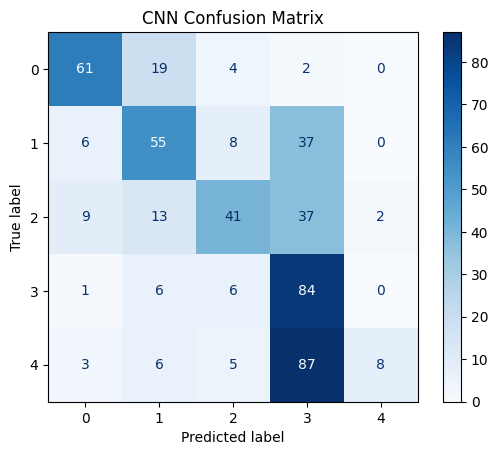

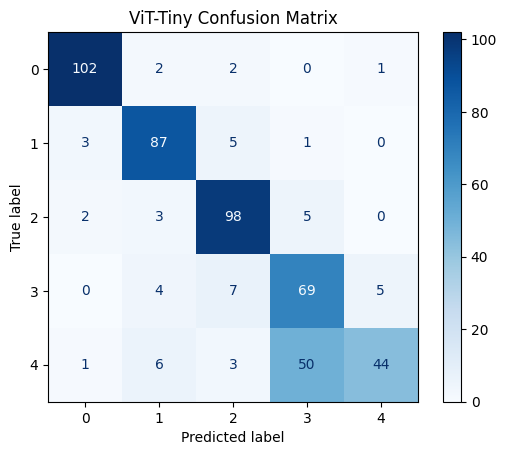

In [59]:
class_names = selected_classes

acc_cnn, f1_cnn, cm_cnn = evaluate_model(model_cnn, val_loader, device)
acc_vit, f1_vit, cm_vit = evaluate_model(model_vit, val_loader_vit, device)

print(f'CNN Accuracy: {acc_cnn:.4f}, Macro-F1: {f1_cnn:.4f}')
print(f'ViT-Tiny Accuracy: {acc_vit:.4f}, Macro-F1: {f1_vit:.4f}')

plot_confusion_matrix(cm_cnn, class_names, 'CNN Confusion Matrix')
plot_confusion_matrix(cm_vit, class_names, 'ViT-Tiny Confusion Matrix')
